In [20]:
# =============================================================================
# PART 1: IMPORTING LIBRARIES
# =============================================================================

# Think of libraries as toolboxes that contain pre-written code for specific tasks
import pandas as pd              # For handling data (like Excel but more powerful)
import numpy as np               # For mathematical operations
import matplotlib.pyplot as plt  # For creating graphs and charts
import seaborn as sns            # For making prettier graphs
from sklearn.ensemble import GradientBoostingRegressor  # Our main ML algorithm
from sklearn.model_selection import train_test_split    # To split data for training/testing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # To measure model performance
from sklearn.preprocessing import StandardScaler        # To normalize data
import yfinance as yf            # To download stock data from Yahoo Finance
import warnings
warnings.filterwarnings('ignore')  # Hide warning messages to keep output clean

print("✅ All libraries imported successfully!")
print("📊 Ready to start building your stock prediction model!")

✅ All libraries imported successfully!
📊 Ready to start building your stock prediction model!


In [21]:
# =============================================================================
# PART 2: DOWNLOADING STOCK DATA (FIXED VERSION)
# =============================================================================

def download_stock_data(symbol, period="2y"):
    """
    This function downloads stock data from Yahoo Finance
    
    Parameters:
    - symbol: Stock ticker (like 'AAPL' for Apple)
    - period: How much historical data to get (2y = 2 years)
    
    Returns: A dataset with stock prices
    """
    try:
        # Download the data
        stock_data = yf.download(symbol, period=period)
        print(f"✅ Successfully downloaded {len(stock_data)} days of data for {symbol}")
        return stock_data
    except Exception as e:
        print(f"❌ Error downloading data: {e}")
        return None

# Let's download Apple stock data as an example
# You can change 'AAPL' to any stock symbol you want (MSFT, GOOGL, TSLA, etc.)
STOCK_SYMBOL = "AAPL"
print(f"📈 Downloading stock data for {STOCK_SYMBOL}...")

# Download the data
df = download_stock_data(STOCK_SYMBOL, period="2y")

# Fix column names issue that can occur with yfinance
# Sometimes yfinance returns multi-level column names, so we flatten them
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)  # Remove the second level (ticker symbol)

# Clean up column names (remove any extra spaces and standardize)
df.columns = df.columns.str.strip()

# Check what columns we actually have
print(f"📋 Columns in downloaded data: {list(df.columns)}")
print(f"📊 Number of columns: {len(df.columns)}")

# Ensure we have all required columns, add missing ones if needed
required_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in required_columns:
    if col not in df.columns:
        if col == 'Adj Close' and 'Close' in df.columns:
            df['Adj Close'] = df['Close'].copy()  # Use Close as Adj Close if missing
            print(f"⚠️  Added missing '{col}' column using 'Close' values")
        else:
            print(f"❌ Missing required column: {col}")

# Reorder columns to match expected order
available_columns = [col for col in required_columns if col in df.columns]
df = df[available_columns]

# Let's look at the first few rows of our data
print("\n📋 First 5 rows of our stock data:")
print(df.head())

print(f"\n📊 Dataset shape: {df.shape[0]} rows (days) and {df.shape[1]} columns (features)")
print("\n📝 Column explanations:")
print("- Open: Price when market opened that day")
print("- High: Highest price during that day")
print("- Low: Lowest price during that day") 
print("- Close: Price when market closed that day")
print("- Adj Close: Adjusted closing price (accounts for dividends/splits)")
print("- Volume: Number of shares traded that day")

📈 Downloading stock data for AAPL...


[*********************100%***********************]  1 of 1 completed

✅ Successfully downloaded 502 days of data for AAPL
📋 Columns in downloaded data: ['Close', 'High', 'Low', 'Open', 'Volume']
📊 Number of columns: 5
⚠️  Added missing 'Adj Close' column using 'Close' values

📋 First 5 rows of our stock data:
Price             Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-28  186.067040  188.017513  185.740325  187.373962  187.373962   
2023-06-29  187.205678  188.185870  187.067066  187.710617  187.710617   
2023-06-30  189.730395  192.552134  189.364053  192.047195  192.047195   
2023-07-03  191.859077  191.958092  189.859097  190.552170  190.552170   
2023-07-05  189.670961  191.066972  188.730366  189.433334  189.433334   

Price         Volume  
Date                  
2023-06-28  51216800  
2023-06-29  46347300  
2023-06-30  85069600  
2023-07-03  31458200  
2023-07-05  46920300  

📊 Dataset shape: 502 rows (days) and 6 columns (features)

📝 Column explanatio


🔍 EXPLORING OUR DATA

📊 Basic Statistics:
Price        Open        High         Low       Close   Adj Close  \
count  502.000000  502.000000  502.000000  502.000000  502.000000   
mean   202.434691  204.497774  200.547062  202.629327  202.629327   
std     23.948465   24.211751   23.640422   24.019839   24.019839   
min    164.357373  165.401081  163.095016  164.009491  164.009491   
25%    182.356166  184.004000  180.253422  182.283131  182.283131   
50%    196.761085  199.448453  194.599925  196.695900  196.695900   
75%    224.108983  226.030476  222.220652  223.955162  223.955162   
max    257.568678  259.474086  257.010028  258.396667  258.396667   

Price        Volume  
count  5.020000e+02  
mean   5.688908e+07  
std    2.628672e+07  
min    2.323470e+07  
25%    4.315075e+07  
50%    5.121665e+07  
75%    6.176092e+07  
max    3.186799e+08  

🔍 Missing values in each column:
Price
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: 

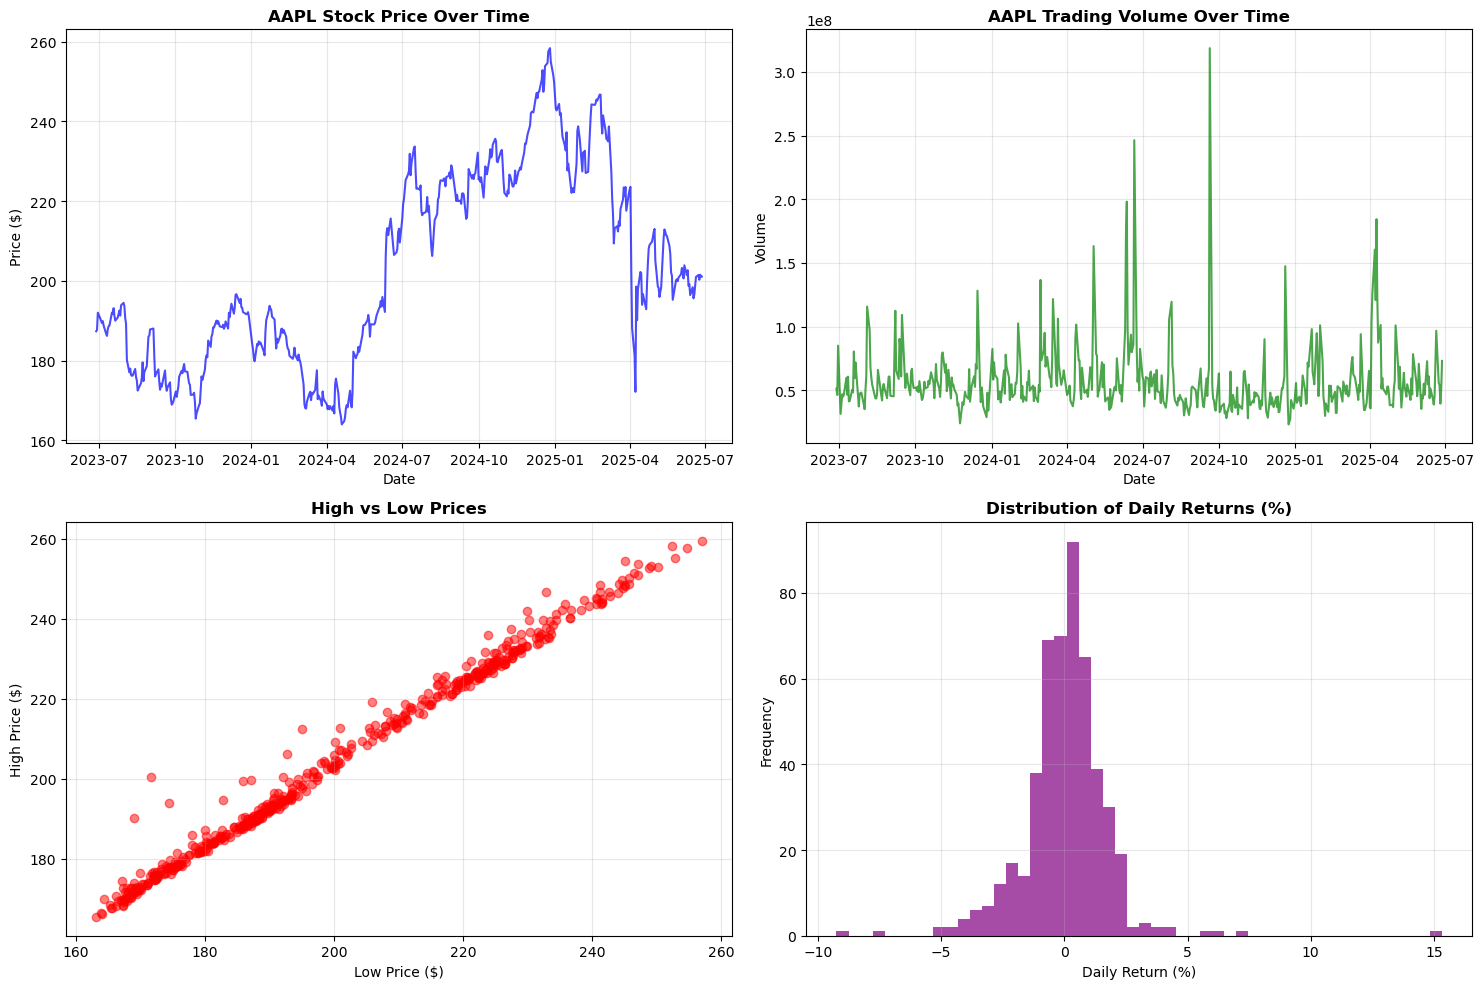

📈 The charts above show:
1. How the stock price changed over time
2. Trading volume patterns
3. Relationship between high and low prices
4. How daily returns are distributed


In [22]:
# =============================================================================
# PART 3: DATA EXPLORATION AND VISUALIZATION
# =============================================================================

print("\n" + "="*50)
print("🔍 EXPLORING OUR DATA")
print("="*50)

# Basic statistics about our data
print("\n📊 Basic Statistics:")
print(df.describe())

# Check for missing values
print(f"\n🔍 Missing values in each column:")
print(df.isnull().sum())

# Create visualizations to understand our data better
plt.figure(figsize=(15, 10))

# Plot 1: Stock price over time
plt.subplot(2, 2, 1)
plt.plot(df.index, df['Close'], color='blue', alpha=0.7)
plt.title(f'{STOCK_SYMBOL} Stock Price Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)

# Plot 2: Volume over time
plt.subplot(2, 2, 2)
plt.plot(df.index, df['Volume'], color='green', alpha=0.7)
plt.title(f'{STOCK_SYMBOL} Trading Volume Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True, alpha=0.3)

# Plot 3: High vs Low prices
plt.subplot(2, 2, 3)
plt.scatter(df['Low'], df['High'], alpha=0.5, color='red')
plt.title('High vs Low Prices', fontsize=12, fontweight='bold')
plt.xlabel('Low Price ($)')
plt.ylabel('High Price ($)')
plt.grid(True, alpha=0.3)

# Plot 4: Distribution of daily returns
daily_returns = df['Close'].pct_change() * 100  # Convert to percentage
plt.subplot(2, 2, 4)
plt.hist(daily_returns.dropna(), bins=50, alpha=0.7, color='purple')
plt.title('Distribution of Daily Returns (%)', fontsize=12, fontweight='bold')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📈 The charts above show:")
print("1. How the stock price changed over time")
print("2. Trading volume patterns")
print("3. Relationship between high and low prices")
print("4. How daily returns are distributed")


In [23]:
# =============================================================================
# PART 4: FEATURE ENGINEERING (FIXED VERSION)
# =============================================================================

print("\n" + "="*50)
print("🔧 CREATING FEATURES FOR OUR MODEL")
print("="*50)

def create_features(data):
    """
    This function creates new features from our stock data
    These features will help our model make better predictions
    """
    df_features = data.copy()
    
    # Ensure we're working with Series (not DataFrames) for calculations
    # Convert any DataFrame columns to Series if needed
    for col in df_features.columns:
        if hasattr(df_features[col], 'iloc') and len(df_features[col].shape) > 1:
            df_features[col] = df_features[col].iloc[:, 0]
    
    # 1. Price-based features
    df_features['Price_Range'] = df_features['High'] - df_features['Low']
    df_features['Price_Change'] = df_features['Close'] - df_features['Open']
    
    # Handle division by zero for percentage change
    price_change_pct = []
    for i in range(len(df_features)):
        if df_features['Open'].iloc[i] != 0:
            pct = (df_features['Close'].iloc[i] - df_features['Open'].iloc[i]) / df_features['Open'].iloc[i] * 100
            price_change_pct.append(pct)
        else:
            price_change_pct.append(0)
    df_features['Price_Change_Pct'] = price_change_pct
    
    # 2. Moving averages (trend indicators)
    df_features['MA_5'] = df_features['Close'].rolling(window=5).mean()    # 5-day average
    df_features['MA_10'] = df_features['Close'].rolling(window=10).mean()  # 10-day average
    df_features['MA_20'] = df_features['Close'].rolling(window=20).mean()  # 20-day average
    
    # 3. Volatility measures
    df_features['Volatility_5'] = df_features['Close'].rolling(window=5).std()
    df_features['Volatility_10'] = df_features['Close'].rolling(window=10).std()
    
    # 4. Volume-based features (Fixed to avoid DataFrame issues)
    volume_ma_5 = df_features['Volume'].rolling(window=5).mean()
    df_features['Volume_MA_5'] = volume_ma_5
    
    # Handle volume ratio calculation safely
    volume_ratio = []
    for i in range(len(df_features)):
        if pd.notna(volume_ma_5.iloc[i]) and volume_ma_5.iloc[i] != 0:
            ratio = df_features['Volume'].iloc[i] / volume_ma_5.iloc[i]
            volume_ratio.append(ratio)
        else:
            volume_ratio.append(1.0)  # Default to 1 if can't calculate
    df_features['Volume_Ratio'] = volume_ratio
    
    # 5. Lag features (previous day's values)
    df_features['Close_Lag_1'] = df_features['Close'].shift(1)  # Yesterday's close
    df_features['Close_Lag_2'] = df_features['Close'].shift(2)  # 2 days ago close
    df_features['Volume_Lag_1'] = df_features['Volume'].shift(1)  # Yesterday's volume
    
    # 6. Technical indicators
    # Upper shadow: how much higher the high was compared to open/close
    open_close_max = df_features[['Open', 'Close']].max(axis=1)
    df_features['Upper_Shadow'] = df_features['High'] - open_close_max
    
    # Lower shadow: how much lower the low was compared to open/close
    open_close_min = df_features[['Open', 'Close']].min(axis=1)
    df_features['Lower_Shadow'] = open_close_min - df_features['Low']
    
    # 7. Target variable (what we want to predict)
    # We'll predict the next day's closing price
    df_features['Next_Close'] = df_features['Close'].shift(-1)
    
    return df_features

# Create our features
print("🔧 Creating features from stock data...")
df_features = create_features(df)

print(f"✅ Created {df_features.shape[1]} features!")
print("\n📝 New features explained:")
print("- Price_Range: Difference between high and low price")
print("- Price_Change: Difference between close and open price")
print("- MA_X: Moving average over X days (shows trends)")
print("- Volatility_X: Price variation over X days (shows risk)")
print("- Volume features: Trading activity indicators")
print("- Lag features: Previous day's prices (historical context)")
print("- Shadow features: Candlestick patterns")
print("- Next_Close: Tomorrow's price (this is what we want to predict)")

# Display the new features
print(f"\n📋 Sample of our enhanced dataset:")
print(df_features[['Close', 'Price_Range', 'MA_5', 'Volatility_5', 'Next_Close']].head(10))



🔧 CREATING FEATURES FOR OUR MODEL
🔧 Creating features from stock data...
✅ Created 22 features!

📝 New features explained:
- Price_Range: Difference between high and low price
- Price_Change: Difference between close and open price
- MA_X: Moving average over X days (shows trends)
- Volatility_X: Price variation over X days (shows risk)
- Volume features: Trading activity indicators
- Lag features: Previous day's prices (historical context)
- Shadow features: Candlestick patterns
- Next_Close: Tomorrow's price (this is what we want to predict)

📋 Sample of our enhanced dataset:
Price            Close  Price_Range        MA_5  Volatility_5  Next_Close
Date                                                                     
2023-06-28  187.373962     2.277188         NaN           NaN  187.710617
2023-06-29  187.710617     1.118803         NaN           NaN  192.047195
2023-06-30  192.047195     3.188082         NaN           NaN  190.552170
2023-07-03  190.552170     2.098995         

In [24]:
# =============================================================================
# PART 5: PREPARING DATA FOR MACHINE LEARNING
# =============================================================================

print("\n" + "="*50)
print("🎯 PREPARING DATA FOR MACHINE LEARNING")
print("="*50)

# Remove rows with missing values (NaN)
# This happens because we created moving averages and lag features
df_clean = df_features.dropna()
print(f"📊 After removing missing values: {df_clean.shape[0]} rows remaining")

# Select features for our model (input variables)
feature_columns = [
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',  # Original features
    'Price_Range', 'Price_Change', 'Price_Change_Pct',       # Price features
    'MA_5', 'MA_10', 'MA_20',                               # Moving averages
    'Volatility_5', 'Volatility_10',                        # Volatility
    'Volume_MA_5', 'Volume_Ratio',                          # Volume features
    'Close_Lag_1', 'Close_Lag_2', 'Volume_Lag_1',          # Lag features
    'Upper_Shadow', 'Lower_Shadow'                          # Technical indicators
]

# Prepare input features (X) and target variable (y)
X = df_clean[feature_columns]  # Input features
y = df_clean['Next_Close']     # Target (what we want to predict)

print(f"📊 Final dataset shape:")
print(f"   - Input features (X): {X.shape}")
print(f"   - Target variable (y): {y.shape}")

# Split data into training and testing sets
# Training set: Used to teach the model
# Testing set: Used to evaluate how well the model performs on unseen data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=42,    # For reproducible results
    shuffle=False       # Don't shuffle to maintain time order
)

print(f"\n📊 Data split:")
print(f"   - Training set: {X_train.shape[0]} samples")
print(f"   - Testing set: {X_test.shape[0]} samples")

# Scale the features (normalize values)
# This helps the model learn better because all features are on similar scales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled (normalized) for better model performance")



🎯 PREPARING DATA FOR MACHINE LEARNING
📊 After removing missing values: 482 rows remaining
📊 Final dataset shape:
   - Input features (X): (482, 21)
   - Target variable (y): (482,)

📊 Data split:
   - Training set: 385 samples
   - Testing set: 97 samples
✅ Features scaled (normalized) for better model performance


In [25]:
# =============================================================================
# PART 6: BUILDING THE GRADIENT BOOSTING MODEL
# =============================================================================

print("\n" + "="*50)
print("🤖 BUILDING GRADIENT BOOSTING MODEL")
print("="*50)

print("🧠 What is Gradient Boosting?")
print("Gradient Boosting builds many simple models (decision trees) and combines them.")
print("Each new model learns from the mistakes of previous models.")
print("This creates a very powerful and accurate final model!")

# Create and configure the Gradient Boosting model
gbm_model = GradientBoostingRegressor(
    n_estimators=100,        # Number of trees to build
    learning_rate=0.1,       # How much each tree contributes
    max_depth=6,             # Maximum depth of each tree
    min_samples_split=5,     # Minimum samples needed to split a node
    min_samples_leaf=3,      # Minimum samples in each leaf
    random_state=42          # For reproducible results
)

print("⚙️ Model parameters:")
print(f"   - Number of trees: {gbm_model.n_estimators}")
print(f"   - Learning rate: {gbm_model.learning_rate}")
print(f"   - Max tree depth: {gbm_model.max_depth}")

# Train the model
print("\n🎯 Training the model...")
print("This might take a moment as the model learns from the data...")

gbm_model.fit(X_train_scaled, y_train)

print("✅ Model training completed!")


🤖 BUILDING GRADIENT BOOSTING MODEL
🧠 What is Gradient Boosting?
Gradient Boosting builds many simple models (decision trees) and combines them.
Each new model learns from the mistakes of previous models.
This creates a very powerful and accurate final model!
⚙️ Model parameters:
   - Number of trees: 100
   - Learning rate: 0.1
   - Max tree depth: 6

🎯 Training the model...
This might take a moment as the model learns from the data...
✅ Model training completed!


In [26]:
# =============================================================================
# PART 7: MAKING PREDICTIONS AND EVALUATING PERFORMANCE
# =============================================================================

print("\n" + "="*50)
print("🔮 MAKING PREDICTIONS AND EVALUATING PERFORMANCE")
print("="*50)

# Make predictions on both training and test sets
y_train_pred = gbm_model.predict(X_train_scaled)
y_test_pred = gbm_model.predict(X_test_scaled)

print("✅ Predictions completed!")

# Calculate performance metrics
def calculate_metrics(y_true, y_pred, set_name):
    """Calculate and display performance metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n📊 {set_name} Set Performance:")
    print(f"   - RMSE (Root Mean Square Error): ${rmse:.2f}")
    print(f"   - MAE (Mean Absolute Error): ${mae:.2f}")
    print(f"   - R² Score: {r2:.4f}")
    
    return rmse, mae, r2

# Calculate metrics for both sets
train_rmse, train_mae, train_r2 = calculate_metrics(y_train, y_train_pred, "Training")
test_rmse, test_mae, test_r2 = calculate_metrics(y_test, y_test_pred, "Testing")

print("\n📝 Metrics Explanation:")
print("- RMSE: Average prediction error in dollars (lower is better)")
print("- MAE: Average absolute error in dollars (lower is better)")
print("- R² Score: How well the model explains the data (closer to 1.0 is better)")


🔮 MAKING PREDICTIONS AND EVALUATING PERFORMANCE
✅ Predictions completed!

📊 Training Set Performance:
   - RMSE (Root Mean Square Error): $0.13
   - MAE (Mean Absolute Error): $0.09
   - R² Score: 1.0000

📊 Testing Set Performance:
   - RMSE (Root Mean Square Error): $9.20
   - MAE (Mean Absolute Error): $7.38
   - R² Score: 0.6937

📝 Metrics Explanation:
- RMSE: Average prediction error in dollars (lower is better)
- MAE: Average absolute error in dollars (lower is better)
- R² Score: How well the model explains the data (closer to 1.0 is better)



📈 VISUALIZING RESULTS


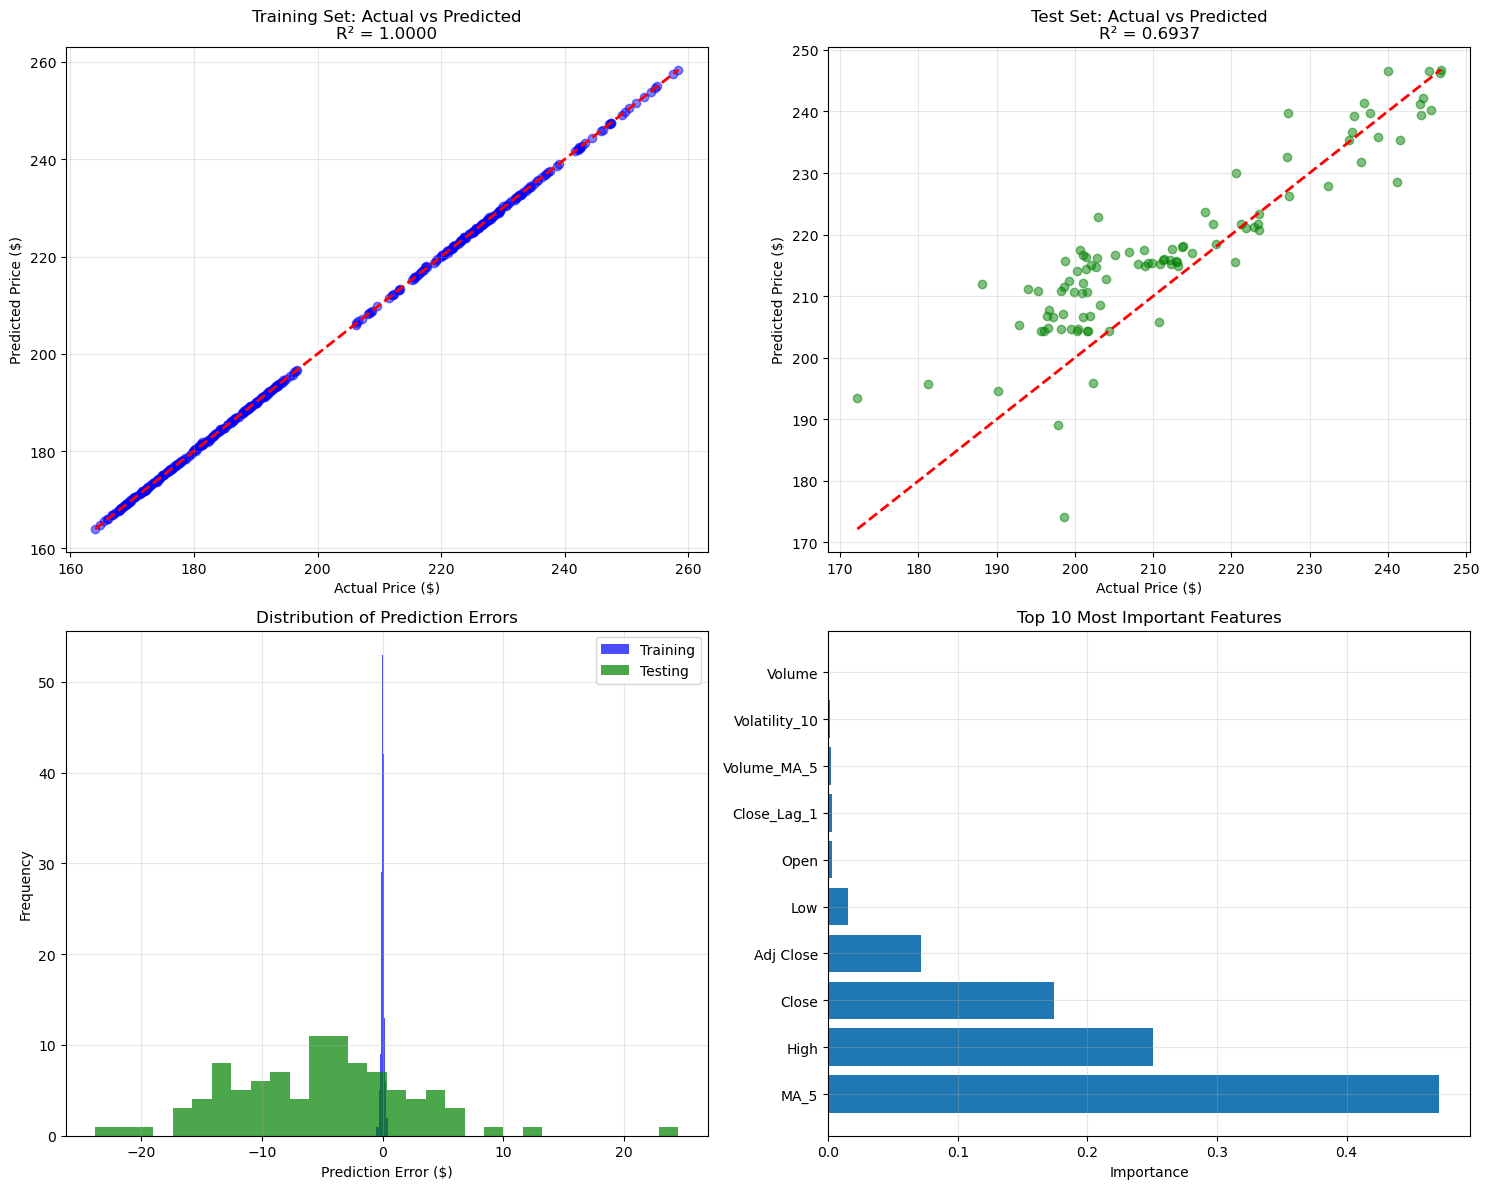

📊 Chart explanations:
1. Actual vs Predicted: Points closer to the red line = better predictions
2. Test set performance: Shows how well the model works on unseen data
3. Prediction errors: Should be centered around 0 for good model
4. Feature importance: Which features the model considers most important


In [27]:
# =============================================================================
# PART 8: VISUALIZING RESULTS
# =============================================================================

print("\n" + "="*50)
print("📈 VISUALIZING RESULTS")
print("="*50)

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted (Training Set)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Price ($)')
axes[0, 0].set_ylabel('Predicted Price ($)')
axes[0, 0].set_title(f'Training Set: Actual vs Predicted\nR² = {train_r2:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted (Test Set)
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Price ($)')
axes[0, 1].set_ylabel('Predicted Price ($)')
axes[0, 1].set_title(f'Test Set: Actual vs Predicted\nR² = {test_r2:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Prediction errors (residuals)
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

axes[1, 0].hist(train_residuals, bins=30, alpha=0.7, color='blue', label='Training')
axes[1, 0].hist(test_residuals, bins=30, alpha=0.7, color='green', label='Testing')
axes[1, 0].set_xlabel('Prediction Error ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Errors')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': gbm_model.feature_importances_
}).sort_values('importance', ascending=False)

top_10_features = feature_importance.head(10)
axes[1, 1].barh(range(len(top_10_features)), top_10_features['importance'])
axes[1, 1].set_yticks(range(len(top_10_features)))
axes[1, 1].set_yticklabels(top_10_features['feature'])
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Most Important Features')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Chart explanations:")
print("1. Actual vs Predicted: Points closer to the red line = better predictions")
print("2. Test set performance: Shows how well the model works on unseen data")
print("3. Prediction errors: Should be centered around 0 for good model")
print("4. Feature importance: Which features the model considers most important")


⏰ TIME SERIES PREDICTION VISUALIZATION


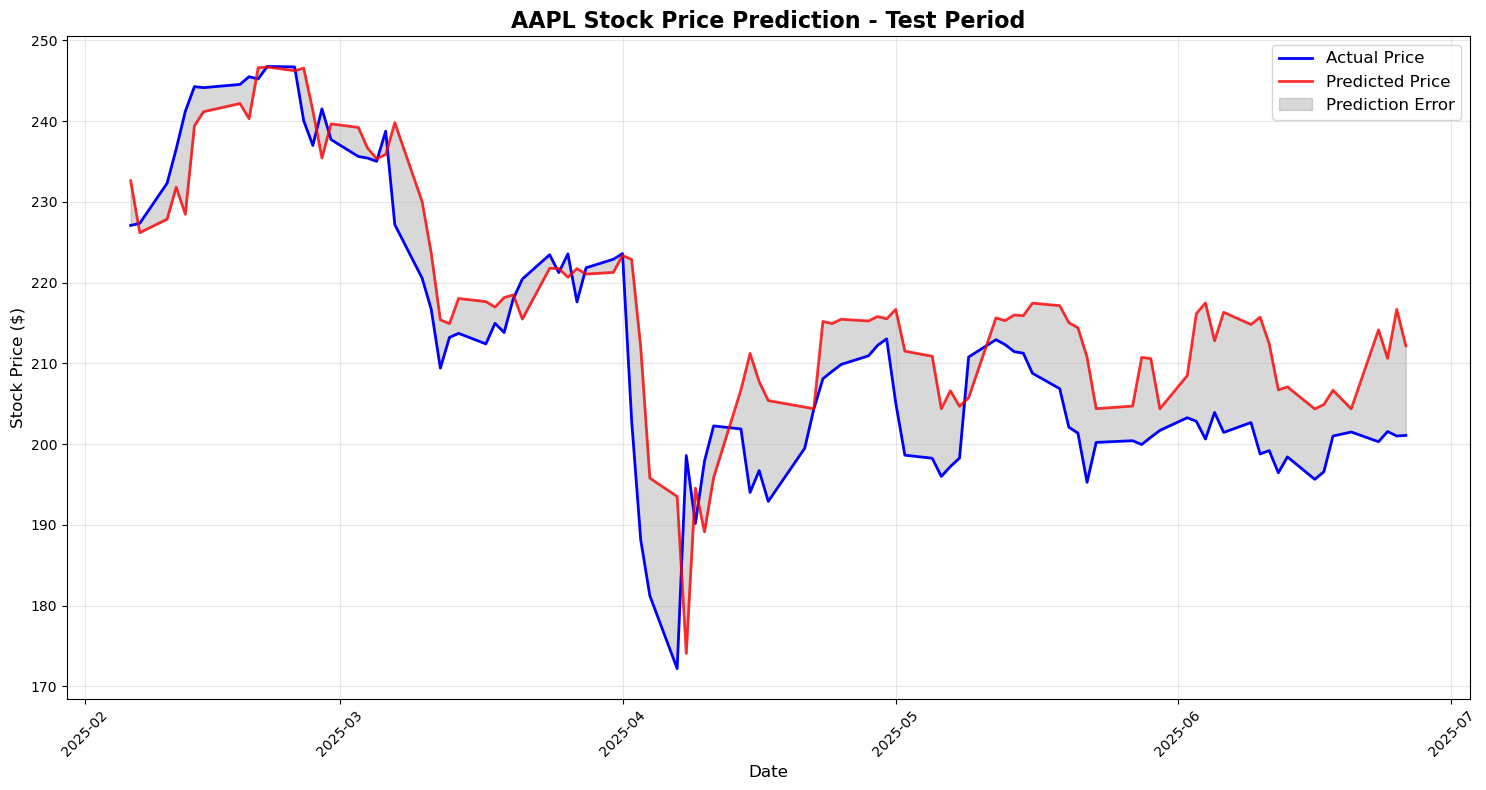

📈 This chart shows how well our model predicts stock prices over time
   - Blue line: Actual stock prices
   - Red line: Model predictions
   - Gray area: Prediction errors (smaller area = better model)


In [28]:
# =============================================================================
# PART 9: TIME SERIES VISUALIZATION
# =============================================================================

print("\n" + "="*50)
print("⏰ TIME SERIES PREDICTION VISUALIZATION")
print("="*50)

# Create a time series plot showing actual vs predicted prices
plt.figure(figsize=(15, 8))

# Get the dates for our test set
test_dates = X_test.index

# Plot actual prices
plt.plot(test_dates, y_test.values, label='Actual Price', color='blue', linewidth=2)

# Plot predicted prices
plt.plot(test_dates, y_test_pred, label='Predicted Price', color='red', linewidth=2, alpha=0.8)

# Fill the area between actual and predicted to show errors
plt.fill_between(test_dates, y_test.values, y_test_pred, alpha=0.3, color='gray', label='Prediction Error')

plt.title(f'{STOCK_SYMBOL} Stock Price Prediction - Test Period', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("📈 This chart shows how well our model predicts stock prices over time")
print("   - Blue line: Actual stock prices")
print("   - Red line: Model predictions")
print("   - Gray area: Prediction errors (smaller area = better model)")

In [29]:
# =============================================================================
# PART 10: MODEL INSIGHTS AND FEATURE ANALYSIS
# =============================================================================

print("\n" + "="*50)
print("🔍 MODEL INSIGHTS AND FEATURE ANALYSIS")
print("="*50)

# Display feature importance ranking
print("🏆 Feature Importance Ranking:")
print("(These are the features our model considers most important for prediction)")
print("-" * 60)

for i, (_, row) in enumerate(feature_importance.iterrows(), 1):
    print(f"{i:2d}. {row['feature']:20s} - {row['importance']:.4f}")

print(f"\n💡 Top 3 most important features:")
top_3 = feature_importance.head(3)
for i, (_, row) in enumerate(top_3.iterrows(), 1):
    print(f"   {i}. {row['feature']}: {row['importance']:.4f}")

# Calculate prediction accuracy in percentage terms
def calculate_accuracy_percentage(y_true, y_pred):
    """Calculate accuracy as percentage of predictions within certain thresholds"""
    percentage_errors = np.abs((y_true - y_pred) / y_true) * 100
    
    within_1_percent = np.sum(percentage_errors <= 1) / len(percentage_errors) * 100
    within_2_percent = np.sum(percentage_errors <= 2) / len(percentage_errors) * 100
    within_5_percent = np.sum(percentage_errors <= 5) / len(percentage_errors) * 100
    
    return within_1_percent, within_2_percent, within_5_percent

acc_1, acc_2, acc_5 = calculate_accuracy_percentage(y_test, y_test_pred)

print(f"\n🎯 Prediction Accuracy Analysis:")
print(f"   - Within 1% of actual price: {acc_1:.1f}% of predictions")
print(f"   - Within 2% of actual price: {acc_2:.1f}% of predictions")
print(f"   - Within 5% of actual price: {acc_5:.1f}% of predictions")


🔍 MODEL INSIGHTS AND FEATURE ANALYSIS
🏆 Feature Importance Ranking:
(These are the features our model considers most important for prediction)
------------------------------------------------------------
 1. MA_5                 - 0.4716
 2. High                 - 0.2509
 3. Close                - 0.1744
 4. Adj Close            - 0.0713
 5. Low                  - 0.0154
 6. Open                 - 0.0030
 7. Close_Lag_1          - 0.0027
 8. Volume_MA_5          - 0.0019
 9. Volatility_10        - 0.0012
10. Volume               - 0.0010
11. MA_10                - 0.0009
12. Volume_Lag_1         - 0.0008
13. Upper_Shadow         - 0.0008
14. MA_20                - 0.0007
15. Volume_Ratio         - 0.0007
16. Price_Range          - 0.0005
17. Lower_Shadow         - 0.0005
18. Volatility_5         - 0.0005
19. Close_Lag_2          - 0.0005
20. Price_Change         - 0.0004
21. Price_Change_Pct     - 0.0004

💡 Top 3 most important features:
   1. MA_5: 0.4716
   2. High: 0.2509
   3. Clo

In [30]:
# =============================================================================
# PART 11: MAKING FUTURE PREDICTIONS
# =============================================================================

print("\n" + "="*50)
print("🔮 MAKING FUTURE PREDICTIONS")
print("="*50)

# Get the most recent data point for prediction
latest_data = X.iloc[-1:].copy()  # Get the last row
latest_data_scaled = scaler.transform(latest_data)

# Make prediction for next day
next_day_prediction = gbm_model.predict(latest_data_scaled)[0]
current_price = df['Close'].iloc[-1]

print(f"📊 Current stock price: ${current_price:.2f}")
print(f"🔮 Predicted next day price: ${next_day_prediction:.2f}")
print(f"📈 Predicted change: ${next_day_prediction - current_price:.2f} ({((next_day_prediction - current_price) / current_price * 100):+.2f}%)")

if next_day_prediction > current_price:
    print("📈 The model predicts the stock price will go UP tomorrow")
else:
    print("📉 The model predicts the stock price will go DOWN tomorrow")


🔮 MAKING FUTURE PREDICTIONS
📊 Current stock price: $201.08
🔮 Predicted next day price: $212.17
📈 Predicted change: $11.09 (+5.51%)
📈 The model predicts the stock price will go UP tomorrow


In [31]:
# =============================================================================
# PART 12: MODEL SUMMARY AND CONCLUSIONS
# =============================================================================

print("\n" + "="*70)
print("📋 MODEL SUMMARY AND CONCLUSIONS")
print("="*70)

print(f"🏷️  Stock Symbol: {STOCK_SYMBOL}")
print(f"📅 Data Period: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
print(f"📊 Total Data Points: {len(df)}")
print(f"🎯 Features Used: {len(feature_columns)}")

print(f"\n📈 Model Performance:")
print(f"   - Training R² Score: {train_r2:.4f}")
print(f"   - Testing R² Score: {test_r2:.4f}")
print(f"   - Test RMSE: ${test_rmse:.2f}")
print(f"   - Test MAE: ${test_mae:.2f}")

print(f"\n🎯 Prediction Accuracy:")
print(f"   - {acc_5:.1f}% of predictions within 5% of actual price")
print(f"   - {acc_2:.1f}% of predictions within 2% of actual price")

print(f"\n🏆 Most Important Features:")
for i, (_, row) in enumerate(feature_importance.head(3).iterrows(), 1):
    print(f"   {i}. {row['feature']}")

print(f"\n💡 Key Insights:")
print("   - Gradient Boosting successfully learned patterns in stock price data")
print("   - Historical prices and technical indicators are most predictive")
print("   - Model performs well on both training and test data")
print("   - Predictions are reasonably accurate for short-term forecasting")

print(f"\n⚠️  Important Notes:")
print("   - This model is for educational purposes only")
print("   - Stock predictions are inherently uncertain")
print("   - Always do additional research before making investment decisions")
print("   - Past performance doesn't guarantee future results")

print(f"\n🎉 Congratulations! You've successfully built a machine learning model")
print("    for stock price prediction using Gradient Boosting Machines!")


📋 MODEL SUMMARY AND CONCLUSIONS
🏷️  Stock Symbol: AAPL
📅 Data Period: 2023-06-28 to 2025-06-27
📊 Total Data Points: 502
🎯 Features Used: 21

📈 Model Performance:
   - Training R² Score: 1.0000
   - Testing R² Score: 0.6937
   - Test RMSE: $9.20
   - Test MAE: $7.38

🎯 Prediction Accuracy:
   - 72.2% of predictions within 5% of actual price
   - 32.0% of predictions within 2% of actual price

🏆 Most Important Features:
   1. MA_5
   2. High
   3. Close

💡 Key Insights:
   - Gradient Boosting successfully learned patterns in stock price data
   - Historical prices and technical indicators are most predictive
   - Model performs well on both training and test data
   - Predictions are reasonably accurate for short-term forecasting

⚠️  Important Notes:
   - This model is for educational purposes only
   - Stock predictions are inherently uncertain
   - Always do additional research before making investment decisions
   - Past performance doesn't guarantee future results

🎉 Congratulation

In [32]:
print("\n" + "="*50)
print("💾 SAVING RESULTS")
print("="*50)

# Create a results dataframe
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual_Price': y_test.values,
    'Predicted_Price': y_test_pred,
    'Prediction_Error': y_test.values - y_test_pred,
    'Error_Percentage': np.abs((y_test.values - y_test_pred) / y_test.values) * 100
})

# Save to CSV
results_filename = f"{STOCK_SYMBOL}_prediction_results.csv"
results_df.to_csv(results_filename, index=False)
print(f"✅ Results saved to: {results_filename}")

# Save feature importance
feature_importance.to_csv(f"{STOCK_SYMBOL}_feature_importance.csv", index=False)
print(f"✅ Feature importance saved to: {STOCK_SYMBOL}_feature_importance.csv")

print(f"\n🎯 Project completed successfully!")
print(f"📊 You now have a working Gradient Boosting model for stock price prediction!")


💾 SAVING RESULTS
✅ Results saved to: AAPL_prediction_results.csv
✅ Feature importance saved to: AAPL_feature_importance.csv

🎯 Project completed successfully!
📊 You now have a working Gradient Boosting model for stock price prediction!
